# Build a Generative Adversarial Neural Network

# 1. Import Dependencies and Data

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [ ]:
!pip list

In [ ]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Brining in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [ ]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

In [ ]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Data and Build Dataset

In [ ]:
# Do some data transformation
import numpy as np

In [ ]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [ ]:
# Getting data out of the pipeline
dataiterator.next()['image']

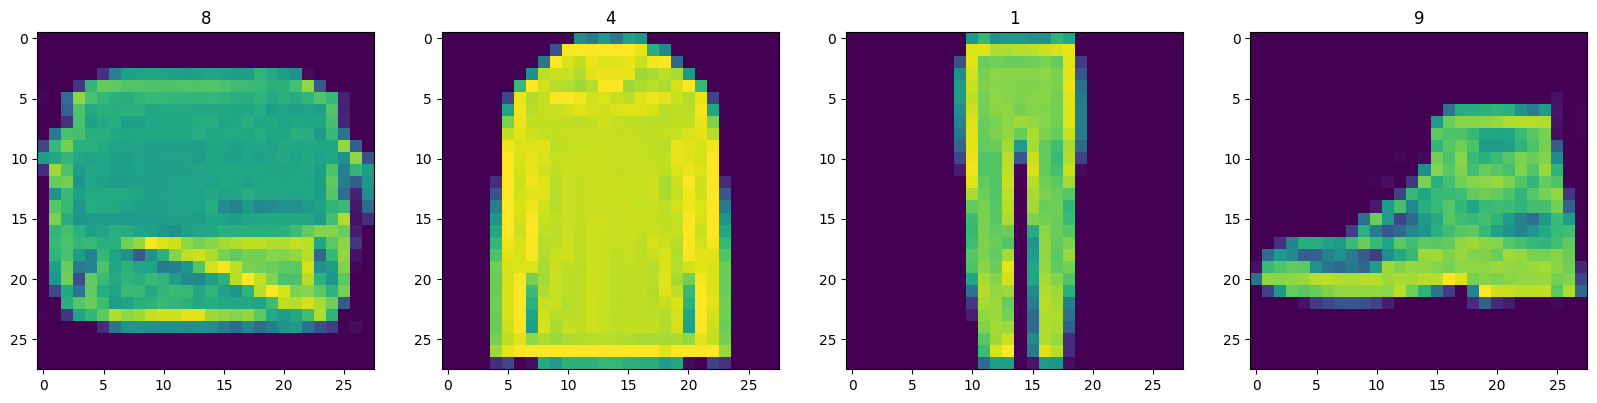

In [ ]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title
    ax[idx].title.set_text(sample['label'])

In [ ]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255

In [ ]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

### 3.1 Import Modelling Components

In [ ]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [ ]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [ ]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 22ms/step


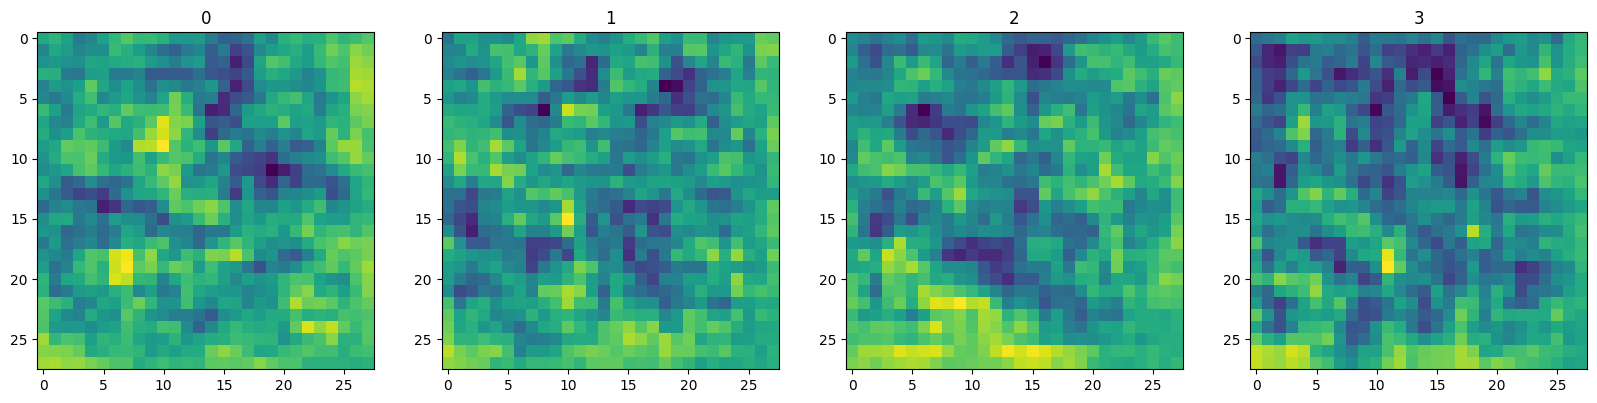

In [ ]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [ ]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_15 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 128)      

In [ ]:
img = img[0]

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [ ]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [ ]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 87s 171ms/step - d_loss: 0.4732 - g_loss: 1.1939
Epoch 2/20
469/469 [==============================] - 79s 169ms/step - d_loss: 0.2783 - g_loss: 2.5889
Epoch 3/20
469/469 [==============================] - 79s 168ms/step - d_loss: 0.3310 - g_loss: 2.8509
Epoch 4/20
469/469 [==============================] - 78s 167ms/step - d_loss: 0.3365 - g_loss: 6.0042
Epoch 5/20
469/469 [==============================] - 79s 169ms/step - d_loss: 0.6655 - g_loss: 0.7789
Epoch 6/20
469/469 [==============================] - 79s 169ms/step - d_loss: 0.5186 - g_loss: 0.5034
Epoch 7/20
469/469 [==============================] - 79s 169ms/step - d_loss: 0.4931 - g_loss: 0.1277
Epoch 8/20
469/469 [==============================] - 79s 169ms/step - d_loss: 0.7179 - g_loss: 0.5810
Epoch 9/20
469/469 [==============================] - 79s 169ms/step - d_loss: 0.6961 - g_loss: 0.6430
Epoch 10/20
469/469 [==============================] - 79s 169ms/step - d

### 4.4 Review Performance

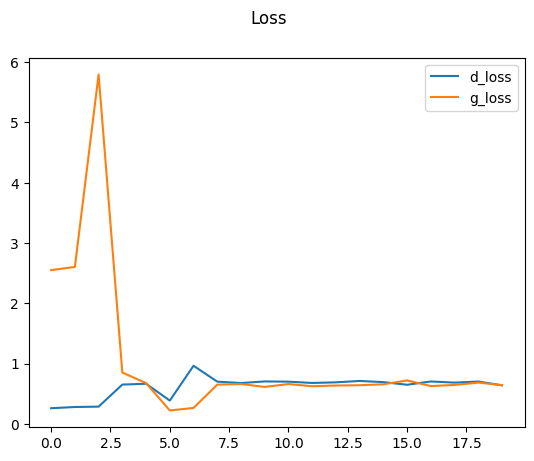

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [ ]:
generator.load_weights('/content/archive/generator.h5')

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 30ms/step


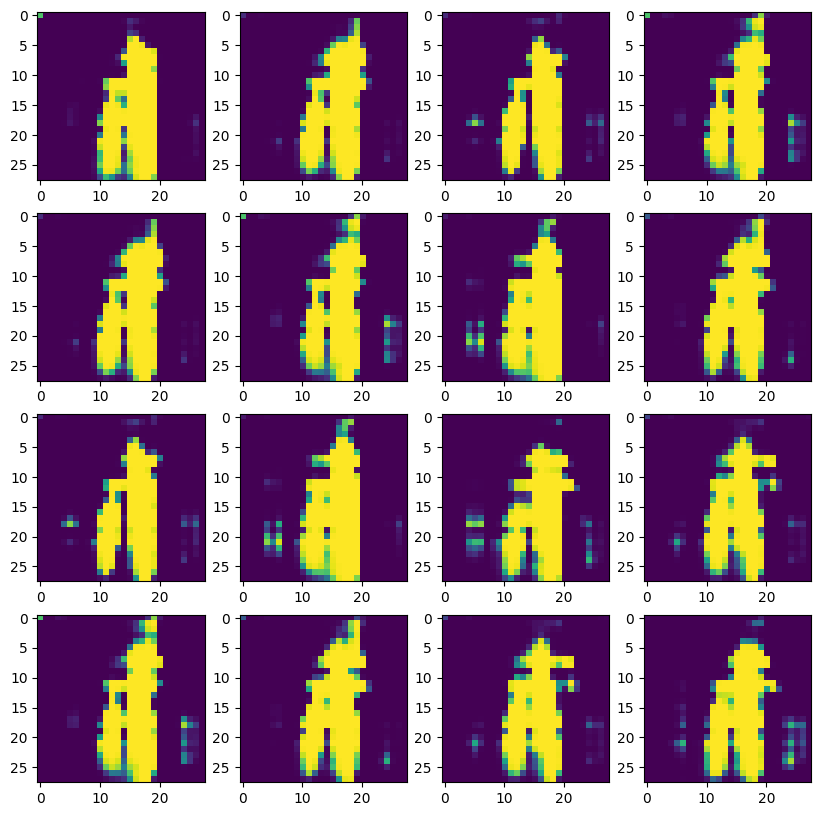

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')